In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score

In [2]:
# The model

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

class TwoWayFM(nn.Module):
    def __init__(self, d, k) -> None:
        super(TwoWayFM, self).__init__()

        self.w0 = nn.Linear(1, 1, bias=True)
        self.w = nn.Embedding(d, 1)
        self.V = nn.Embedding(d, k)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        square_of_sum = torch.sum(self.V(x), dim=1) ** 2
        sum_of_square = torch.sum(self.V(x) ** 2, dim=1)
        x = self.w0(torch.sum(self.w(x), dim=1)) + 0.5 * (square_of_sum - sum_of_square).sum(dim=1, keepdim=True)
        return self.sigmoid(x)
    

class TwoWayFMDataset(Dataset):
    def __init__(self, X: pd.DataFrame) -> None:
        self.X = X.copy()
        user_padding = self.X['user_id'].nunique()
        self.X['item_id'] = self.X['item_id'] + user_padding # padding item_id

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X.iloc[idx]
        X = torch.tensor([row['user_id'], row['item_id']], dtype=torch.long)
        y = torch.tensor([row['rating']], dtype=torch.float32)
        return X, y

cuda


In [3]:
# Generate synthetic data

np.random.seed(0)
users = 100
items = 2000
events = 50000

user_ids = np.random.randint(0, users, events)
item_ids = np.random.randint(0, items, events)
y = np.random.randint(0, 2, events)

X = pd.DataFrame({'user_id': user_ids, 'item_id': item_ids, 'rating': y})

assert X['user_id'].nunique() == users, 'Number of users is not correct'
assert X['item_id'].nunique() == items, 'Number of items is not correct'

X

,user_id,item_id,rating
0,44,585,1
1,47,1645,1
2,64,384,0
3,67,967,0
4,67,1785,0
...,...,...,...
49995,52,1366,0
49996,28,1431,0
49997,97,413,0
49998,89,891,1


<Axes: >

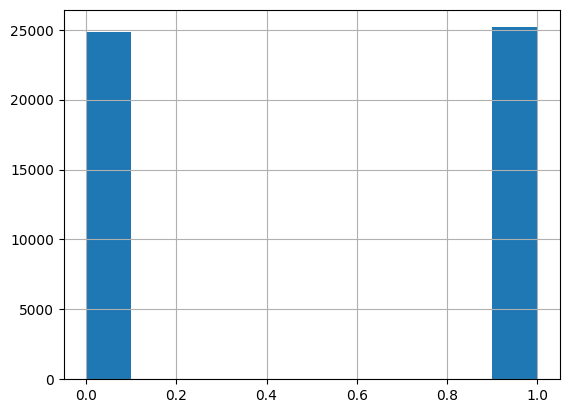

In [4]:
X['rating'].hist()

In [4]:
gs = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(gs.split(X, groups=X['user_id']))

train = X.iloc[train_idx]
test = X.iloc[test_idx]

train_dataset = TwoWayFMDataset(train)
test_dataset = TwoWayFMDataset(test)

In [5]:
FM = TwoWayFM(users + items, 32).to(DEVICE)

FM

TwoWayFM(
  (w0): Linear(in_features=1, out_features=1, bias=True)
  (w): Embedding(2100, 1)
  (V): Embedding(2100, 32)
  (sigmoid): Sigmoid()
)

In [7]:
from tqdm.auto import tqdm

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(FM.parameters(), lr=0.001)

for epoch in tqdm(range(1, 11)):
    FM.train()
    for i, (X, y) in enumerate(train_loader):
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        y_hat = FM(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
    
    if epoch % 10 != 0:
        continue

    FM.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):
            X = X.to(DEVICE)
            y_hat = FM(X)
            preds.extend(y_hat.cpu().detach().numpy())
            targets.extend(y)

    auc = roc_auc_score(targets, preds)
    print(f'AUC: {auc:.4f}')


  0%|          | 0/10 [00:00<?, ?it/s]

AUC: 0.5026
